In [1]:
%matplotlib inline

# Entrenamiento de un clasificador (Cifar10)

Eso es todo. Ha visto cómo definir redes neuronales, calcular pérdidas y actualizar los pesos de la red.

Ahora podrías estar pensando

## ¿Qué pasa con los datos?

Generalmente, cuando tiene que lidiar con datos de imagen, texto, audio o video, puede usar paquetes de Python estándar que cargan datos en una matriz de Numpy. Luego puede convertir esta matriz en un archivo `torch.*Tensor`.

 * Para las imágenes, los paquetes como Pillow, OpenCV son útiles
 * Para audio, paquetes como scipy y librosa
 * Para el texto, la carga sin procesar basada en Python o Cython, o NLTK y SpaCy son útiles

Específicamente para la visión, hemos creado un paquete llamado `torchvision`, que tiene cargadores de datos para conjuntos de datos comunes como ImageNet, CIFAR10, MNIST, etc. y transformadores de datos para imágenes, a saber, `torchvision.datasets` y `torch.utils.data.DataLoader`.

Esto proporciona una gran comodidad y evita escribir código repetitivo.

Para este tutorial, usaremos el conjunto de datos CIFAR10. Tiene las clases: 'avión', 'automóvil', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión'. Las imágenes en CIFAR-10 son de tamaño 3x32x32, es decir, imágenes en color de 3 canales de 32x32 píxeles de tamaño.

![cifar10](https://pytorch.org/tutorials/_images/cifar10.png)

## Entrenamiento de un clasificador de imágenes

Realizaremos los siguientes pasos en orden:

 1. Cargue y normalice los conjuntos de datos de prueba y entrenamiento CIFAR10 usando torchvision
 2. Definir una red neuronal convolucional
 3. Definir una función de pérdida
 4. Entrene a la red con los datos de entrenamiento
 5. Pruebe la red en los datos de prueba

### 1. Cargue y normalice CIFAR10

Usando `torchvision`, es extremadamente fácil cargar CIFAR10.

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

La salida de los conjuntos de datos de torchvision son imágenes PILImage de rango [0, 1]. Los transformamos en Tensores de rango normalizado [-1, 1].

 > **Nota**: 
 > Si se ejecuta en Windows y obtiene un BrokenPipeError, intente configurar el num_worker de torch.utils.data.DataLoader () en 0.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

170499072it [01:42, 1659686.15it/s]                               


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Permítanos mostrarle algunas de las imágenes de entrenamiento, por diversión.

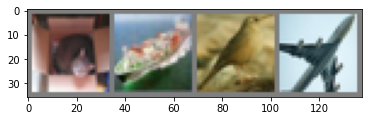

  cat  ship  bird plane


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### 2. Definir una red neuronal convolucional

Copie la red neuronal del cuaderno de Redes neuronales anterior y modifíquela para tomar imágenes de 3 canales (en lugar de imágenes de 1 canal como se definió)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Defina una función de pérdida y un optimizador

Usemos una pérdida de clasificación de entropía cruzada y SGD con impulso

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Entrenar la red

Aquí es cuando las cosas empiezan a ponerse interesantes. Simplemente tenemos que recorrer nuestro iterador de datos, alimentar las entradas a la red y optimizar.

In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

C:\Users\mfnunez\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 2.199
[1,  4000] loss: 1.854
[1,  6000] loss: 1.687
[1,  8000] loss: 1.584
[1, 10000] loss: 1.538
[1, 12000] loss: 1.495
[2,  2000] loss: 1.401
[2,  4000] loss: 1.364
[2,  6000] loss: 1.331
[2,  8000] loss: 1.351
[2, 10000] loss: 1.291
[2, 12000] loss: 1.300
Finished Training


Guardemos rápidamente nuestro modelo entrenado

In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Consulte [aquí](https://pytorch.org/docs/stable/notes/serialization.html) para obtener más detalles sobre cómo guardar modelos de PyTorch

### 5. Testear la red en los datos de prueba

Hemos entrenado la red para 2 pasadas sobre el conjunto de datos de entrenamiento. Pero tenemos que comprobar si la red ha aprendido algo.

Comprobaremos esto prediciendo la etiqueta de clase que genera la red neuronal y comparándola con la verdad del terreno. Si la predicción es correcta, agregamos la muestra a la lista de predicciones correctas.

De acuerdo, primer paso. Vamos a mostrar una imagen del conjunto de prueba para familiarizarnos

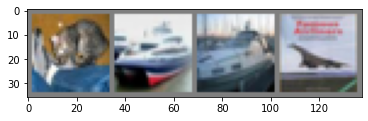

GroundTruth:    cat  ship  ship plane


In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

A continuación, carguemos de nuevo en nuestro modelo guardado (nota: guardar y volver a cargar el modelo no fue necesario aquí, solo lo hicimos para ilustrar cómo hacerlo):

In [12]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Bien, ahora veamos qué cree la red neuronal que son estos ejemplos anteriores

In [13]:
outputs = net(images)

Las salidas son energías para las 10 clases. Cuanto mayor es la energía de una clase, más piensa la red que la imagen es de esa clase en particular. Entonces, obtengamos el índice de la energía más alta:

In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog  ship  ship  ship


Los resultados parecen bastante buenos.

Veamos cómo funciona la red en todo el conjunto de datos

In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


Eso se ve mucho mejor que el azar, que es un 10% de precisión (elegir al azar una clase de 10 clases). Parece que la red aprendió algo.

Mmmm, ¿cuáles son las clases que funcionaron bien y las clases que no funcionaron bien?

In [16]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data    
        outputs = net(images)    
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class plane is: 69.7 %
Accuracy for class car   is: 57.5 %
Accuracy for class bird  is: 52.7 %
Accuracy for class cat   is: 20.7 %
Accuracy for class deer  is: 40.0 %
Accuracy for class dog   is: 48.4 %
Accuracy for class frog  is: 72.0 %
Accuracy for class horse is: 60.2 %
Accuracy for class ship  is: 68.0 %
Accuracy for class truck is: 58.0 %


Bien, ¿y qué sigue?

¿Cómo ejecutamos estas redes neuronales en la GPU?

## Entrenamiento en GPU

Así como transfieres un Tensor a la GPU, transfieres la red neuronal a la GPU.

Primero definamos nuestro dispositivo como el primer dispositivo cuda visible si tenemos CUDA disponible

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


El resto de esta sección asume que devicees un dispositivo CUDA.

Luego, estos métodos revisarán recursivamente todos los módulos y convertirán sus parámetros y búferes en tensores CUDA:

```python
    net.to(device)
```


Recuerde que también tendrá que enviar las entradas y los objetivos en cada paso a la GPU:

```python
    inputs, labels = data[0].to(device), data[1].to(device)
```

¿Por qué no noto una aceleración MASIVA en comparación con la CPU? Porque su red es realmente pequeña